In [2]:
!sudo apt-get update
!sudo apt-get install -y swig g++ python3-dev
!pip install gymnasium[box2d] torch


Hit:1 https://packages.cloud.google.com/apt gcsfuse-jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,659 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [77.5 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:13 http://security.ubuntu.com/ubuntu j

Using device: cpu
State size: 24, Action size: 9
Training for 600 episodes.
Episode 1	Score: -113.10	Average Score (Last 100): -113.10	Epsilon: 0.9950
Episode 2	Score: -113.76	Average Score (Last 100): -113.43	Epsilon: 0.9900
Episode 3	Score: -16.24	Average Score (Last 100): -81.03	Epsilon: 0.9851
Episode 4	Score: -113.83	Average Score (Last 100): -89.23	Epsilon: 0.9801
Episode 5	Score: -15.74	Average Score (Last 100): -74.53	Epsilon: 0.9752
Episode 6	Score: -108.15	Average Score (Last 100): -80.14	Epsilon: 0.9704
Episode 7	Score: -113.19	Average Score (Last 100): -84.86	Epsilon: 0.9655
Episode 8	Score: -106.57	Average Score (Last 100): -87.57	Epsilon: 0.9607
Episode 9	Score: -14.66	Average Score (Last 100): -79.47	Epsilon: 0.9559
Episode 10	Score: -23.69	Average Score (Last 100): -73.89	Epsilon: 0.9511
Episode 11	Score: -99.56	Average Score (Last 100): -76.23	Epsilon: 0.9464
Episode 12	Score: -104.03	Average Score (Last 100): -78.54	Epsilon: 0.9416
Episode 13	Score: -97.33	Average Sco

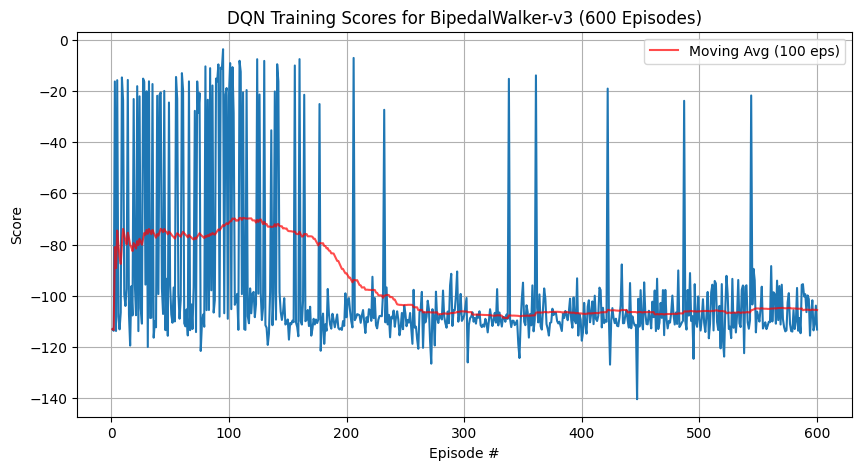

In [6]:
import gymnasium as g
import numpy as np
import torch
import torch.nn as n
import torch.optim as o
import random
from collections import deque, namedtuple
import time
import os
import matplotlib.pyplot as p

ENV = "BipedalWalker-v3"
ACTS = [
    np.array([0, 0, 0, 0], dtype=np.float32),
    np.array([-1, 0, 0, 0], dtype=np.float32),
    np.array([1, 0, 0, 0], dtype=np.float32),
    np.array([0, -1, 0, 0], dtype=np.float32),
    np.array([0, 1, 0, 0], dtype=np.float32),
    np.array([0, 0, -1, 0], dtype=np.float32),
    np.array([0, 0, 1, 0], dtype=np.float32),
    np.array([0, 0, 0, -1], dtype=np.float32),
    np.array([0, 0, 0, 1], dtype=np.float32),
]
NA = len(ACTS)

BUF = int(1e5)
BS = 64
G = 0.99
T = 1e-3
LR = 5e-4
UE = 4
TUE = 100
EPS_S = 1.0
EPS_E = 0.01
EPS_D = 0.995
EP = 600
ST = 1000
SD = 42
DIR = "dqn_models"

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {dev}")

class Net(n.Module):
    def __init__(self, s, a, seed, h1=128, h2=128):
        super(Net, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.l1 = n.Linear(s, h1)
        self.l2 = n.Linear(h1, h2)
        self.l3 = n.Linear(h2, a)

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        return self.l3(x)

Tr = namedtuple("Tr", ("s", "a", "r", "ns", "d"))

class Buf:
    def __init__(self, size, bsz, seed):
        self.mem = deque(maxlen=size)
        self.bsz = bsz
        self.seed = random.seed(seed)

    def add(self, s, a, r, ns, d):
        self.mem.append(Tr(s, a, r, ns, d))

    def sample(self):
        ex = random.sample(self.mem, k=self.bsz)
        s = torch.from_numpy(np.vstack([e.s for e in ex if e])).float().to(dev)
        a = torch.from_numpy(np.vstack([e.a for e in ex if e])).long().to(dev)
        r = torch.from_numpy(np.vstack([e.r for e in ex if e])).float().to(dev)
        ns = torch.from_numpy(np.vstack([e.ns for e in ex if e])).float().to(dev)
        d = torch.from_numpy(np.vstack([e.d for e in ex if e]).astype(np.uint8)).float().to(dev)
        return (s, a, r, ns, d)

    def __len__(self):
        return len(self.mem)

class Agent:
    def __init__(self, s, a, seed):
        self.s = s
        self.a = a
        self.seed = random.seed(seed)
        self.q1 = Net(s, a, seed).to(dev)
        self.q2 = Net(s, a, seed).to(dev)
        self.opt = o.Adam(self.q1.parameters(), lr=LR)
        self.sync(self.q1, self.q2)
        self.buf = Buf(BUF, BS, seed)
        self.ts = 0
        self.tu = 0

    def step(self, s, a, r, ns, d):
        self.buf.add(s, a, r, ns, d)
        self.ts = (self.ts + 1) % UE
        if self.ts == 0 and len(self.buf) > BS:
            self.learn(self.buf.sample(), G)
        self.tu = (self.tu + 1) % TUE
        if self.tu == 0:
            self.soft(self.q1, self.q2, T)

    def act(self, s, eps=0.):
        s = torch.from_numpy(s).float().unsqueeze(0).to(dev)
        self.q1.eval()
        with torch.no_grad():
            qv = self.q1(s)
        self.q1.train()
        idx = np.argmax(qv.cpu().data.numpy()) if random.random() > eps else random.choice(np.arange(self.a))
        return idx, ACTS[idx]

    def learn(self, ex, gamma):
        s, a, r, ns, d = ex
        qn = self.q2(ns).detach().max(1)[0].unsqueeze(1)
        qt = r + (gamma * qn * (1 - d))
        qe = self.q1(s).gather(1, a)
        loss = n.MSELoss()(qe, qt)
        self.opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q1.parameters(), 1.0)
        self.opt.step()

    def soft(self, lm, tm, tau):
        for tp, lp in zip(tm.parameters(), lm.parameters()):
            tp.data.copy_(tau * lp.data + (1.0 - tau) * tp.data)

    def sync(self, lm, tm):
        tm.load_state_dict(lm.state_dict())

    def save(self, f):
        torch.save(self.q1.state_dict(), f)

    def load(self, f):
        self.q1.load_state_dict(torch.load(f, map_location=dev))
        self.sync(self.q1, self.q2)
        print(f"Model loaded from {f}")

def train():
    e = g.make(ENV, hardcore=False, render_mode=None)
    ss = e.observation_space.shape[0]
    asz = NA
    print(f"State size: {ss}, Action size: {asz}")
    print(f"Training for {EP} episodes.")
    ag = Agent(ss, asz, SD)
    os.makedirs(DIR, exist_ok=True)
    sc = []
    win = deque(maxlen=100)
    eps = EPS_S
    t0 = time.time()

    for i in range(1, EP + 1):
        s, _ = e.reset(seed=SD + i)
        sc_i = 0
        for _ in range(ST):
            ai, ca = ag.act(s, eps)
            ns, r, term, trunc, _ = e.step(ca)
            done = term or trunc
            ag.step(s, ai, r, ns, done)
            s = ns
            sc_i += r
            if done:
                break
        win.append(sc_i)
        sc.append(sc_i)
        eps = max(EPS_E, EPS_D * eps)
        avg = np.mean(win)
        print(f'Episode {i}\tScore: {sc_i:.2f}\tAvg: {avg:.2f}\tEps: {eps:.4f}')

    e.close()
    t1 = time.time()
    print(f"\nDone in {EP} episodes. Time: {t1 - t0:.2f} sec ({(t1 - t0) / 60:.2f} min)")
    mpath = os.path.join(DIR, f'dqn_{ENV}_final_{EP}eps.pth')
    ag.save(mpath)
    print(f"Saved to: {mpath}")

    f = p.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    p.plot(np.arange(1, len(sc) + 1), sc)
    ma = [np.mean(sc[max(0, i-100):i+1]) for i in range(len(sc))]
    p.plot(np.arange(1, len(sc) + 1), ma, label='MA (100)', color='red', alpha=0.7)
    p.ylabel('Score')
    p.xlabel('Episode')
    p.title(f'DQN on {ENV}')
    p.legend()
    p.grid(True)
    pf = f'dqn_{ENV}_scores_{EP}eps.png'
    p.savefig(pf)
    print(f"Plot saved to: {pf}")
    p.show()

if __name__ == "__main__":
    train()